In [2]:
from football_odds.models import DoublePoisson
from football_odds.utils.connectors import QuestDB
from datetime import datetime, timedelta
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score, roc_curve, auc, RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None

## Getting the data
* Write down the query to get the data in the shape specified by the model
* Define the training data by setting fixture_date_train_from/to (in this example, 2021)
* Define the matches from the league we want to include (England Premier League)

In [3]:
Q = r'''
select
  dlf.league_name, 
  dlf.season,
  dff.fixture_date,
  dtfh.team_name as home_team_name, 
  dtfa.team_name as away_team_name, 
  dff.teams_home_winner, 
  CASE
    WHEN dff.goals_home = dff.goals_away THEN 'DRAW' 
    WHEN dff.goals_home > dff.goals_away THEN 'HOME'
    WHEN dff.goals_home < dff.goals_away THEN 'AWAY'
  END as winner,
  dff.goals_home, 
  dff.goals_away,
from dim_fixtures_fa dff
inner join dim_leagues_fa dlf
  on dlf.league_id = dff.league_id and dff.league_season = dlf.season
inner join dim_teams_fa dtfh
  on dtfh.team_id = dff.teams_home_id
inner join dim_teams_fa dtfa
  on dtfa.team_id = dff.teams_away_id
where 1=1
  and dlf.league_name IN ('{league_name}')
  and goals_home is not null and goals_away is not null
  and fixture_date >= '{fixture_date_from}'
  and fixture_date < '{fixture_date_to}'
;
'''

In [4]:
fixture_date_train_from = '2021-01-01'
fixture_date_train_to = '2021-12-31'
fixture_date_test_to = '2023-12-31'

leagues = ['Premier League']
if isinstance(leagues, list):
    leagues = "\',\'".join(leagues)

query_train = Q.format(
    league_name=leagues,
    fixture_date_from=fixture_date_train_from,
    fixture_date_to=fixture_date_test_to,
)

df_train_test = QuestDB().execute_query(query_train)
df_train = df_train_test[df_train_test.fixture_date <= fixture_date_train_to]

**[2024-02-12 10:46:37.467867]
select
  dlf.league_name,
  dlf.season,
  dff.fixture_date,
  dtfh.team_name as home_team_name,
  dtfa.team_name as away_team_name,
  dff.teams_home_winner,
  CASE
    WHEN dff.goals_home = dff.goals_away THEN 'DRAW'
    WHEN dff.goals_home > dff.goals_away THEN 'HOME'
    WHEN dff.goals_home < dff.goals_away THEN 'AWAY'
  END as winner,
  dff.goals_home,
  dff.goals_away,
from dim_fixtures_fa dff
inner join dim_leagues_fa dlf
  on dlf.league_id = dff.league_id and dff.league_season = dlf.season
inner join dim_teams_fa dtfh
  on dtfh.team_id = dff.teams_home_id
inner join dim_teams_fa dtfa
  on dtfa.team_id = dff.teams_away_id
where 1=1
  and dlf.league_name IN ('Premier League')
  and goals_home is not null and goals_away is not null
  and fixture_date >= '2021-01-01'
  and fixture_date < '2023-12-31'
;
**[2024-02-12 10:46:41.432853] Ended executing Query


## Model Training
TODO: Train the model with varying hyperparameters, optionally use `sklearn.gridsearchcv` or similar.

Model results agree with our analysis: Manchester City have among the highest attacking/defensive strength overall

In [5]:
dp = DoublePoisson(zeta=0.0065/7)
dp.fit(data=df_train)

dp

Fitting model using 406 matches...done


                     attack   defence  home_adv
Norwich            0.404155  1.565253  1.123117
Sheffield Utd      0.513921  1.189155  1.123117
Fulham             0.594334  0.931843  1.123117
Wolves             0.789110  0.832755  1.123117
Brighton           0.911153  0.711960  1.123117
Burnley            0.971843  1.087918  1.123117
Southampton        0.987957  1.344159  1.123117
Everton            1.043236  1.055345  1.123117
West Brom          1.082735  1.371155  1.123117
Newcastle          1.096443  1.387102  1.123117
Brentford          1.115397  1.028414  1.123117
Crystal Palace     1.132317  1.120767  1.123117
Aston Villa        1.170410  1.012215  1.123117
Leeds              1.183448  1.108993  1.123117
Watford            1.249296  1.480198  1.123117
Tottenham          1.481777  0.963183  1.123117
Chelsea            1.550307  0.558276  1.123117
Arsenal            1.556247  0.794763  1.123117
Manchester United  1.626767  0.858075  1.123117
Leicester          1.671372  1.163403  1

## Model Evaluation
* **Precision, Recall, F1-Score and Accuracy** are measured based on the correct classification of HOME/DRAW/AWAY winner
* **RMSE** is measured between the derived probability winning vs the actual outcome
* We run the results in monthly batches to see the effect of concept drift if any
* We compare this to a dummy model that always guesses that the HOME team will win

In [6]:
df_test = df_train_test[df_train_test.fixture_date > fixture_date_train_to]

expected_winner_list = []
expected_winner_prob = []
for i, row in df_test.iterrows():
    try:
        mo = dp.test(row.home_team_name, row.away_team_name)
    except AssertionError:
        # Will be dropped anyway
        expected_winner_list.append(np.nan)
        expected_winner_prob.append(np.nan)
        continue
        
    outcomes = ['HOME', 'DRAW', 'AWAY']
    expected_winner = outcomes[np.argmax(mo.match_odds())]
    expected_winner_list.append(expected_winner)
    expected_winner_prob.append(max(mo.match_odds()))

df_test['expected_winner'] = expected_winner_list
df_test['expected_winner_prob'] = expected_winner_prob
df_test['is_correct_pred'] = df_test.expected_winner == df_test.winner
df_test = df_test[~df_test.expected_winner.isna()]

## Results
Below we plot the metrics of the model in monthly increments. We can note a few things.
* Overall accuracy of 52% (keeping in mind that this is a 3-class classification problem)
* Weighted F1-Score of 61% for HOME guesses and 51% for AWAY guesses
* The model almost never predicts a DRAW
* AUC of 62%
* Overall RMSE of 0.49
* Concept drift not obvious from the plots, and further analysis is required

(array([18993., 19052., 19113., 19174., 19236., 19297., 19358., 19417.,
        19478., 19539., 19601., 19662.]),
 [Text(18993.0, 0, '2022-01'),
  Text(19052.0, 0, '2022-03'),
  Text(19113.0, 0, '2022-05'),
  Text(19174.0, 0, '2022-07'),
  Text(19236.0, 0, '2022-09'),
  Text(19297.0, 0, '2022-11'),
  Text(19358.0, 0, '2023-01'),
  Text(19417.0, 0, '2023-03'),
  Text(19478.0, 0, '2023-05'),
  Text(19539.0, 0, '2023-07'),
  Text(19601.0, 0, '2023-09'),
  Text(19662.0, 0, '2023-11')])

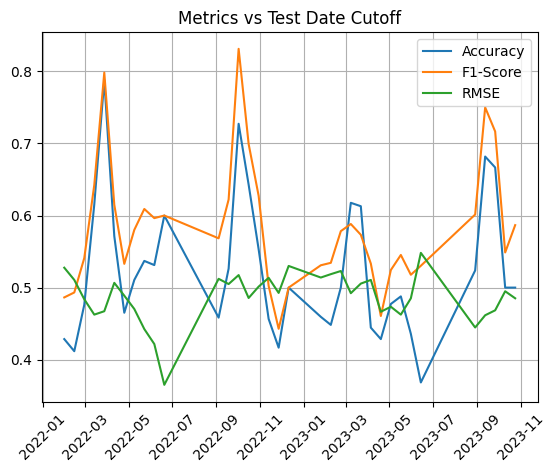

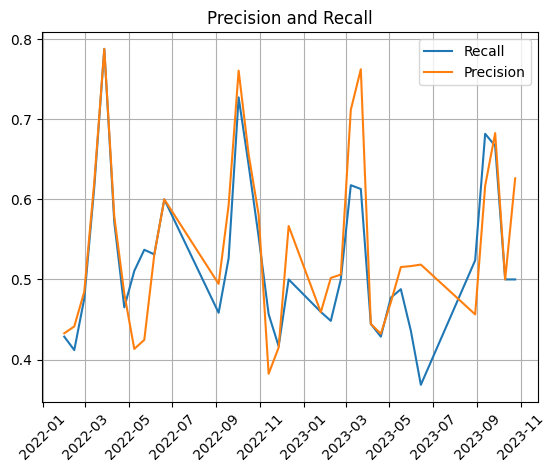

In [7]:
date_test_from = datetime.strptime(fixture_date_train_to, '%Y-%m-%d') + timedelta(days=1)
date_test_to = datetime.strptime(fixture_date_train_to, '%Y-%m-%d') + timedelta(days=31)

date_max = df_test.fixture_date.max()

date_cutoff = []
f1 = []
recall = []
precision = []
accuracy = []
rmse = []
while date_test_to < df_test.fixture_date.max():
    df_test_part = df_test[(df_test.fixture_date <= date_test_to)&(df_test.fixture_date > date_test_from)]
    if len(df_test_part) == 0:
        date_test_from += timedelta(days=31)
        date_test_to += timedelta(days=31)
        continue
    
    rep = classification_report(y_true=df_test_part.winner, y_pred=df_test_part.expected_winner, zero_division=np.nan, output_dict=True)
    date_cutoff.append(date_test_to)
    accuracy.append(rep['accuracy'])
    f1.append(rep['weighted avg']['f1-score'])
    recall.append(rep['weighted avg']['recall'])
    precision.append(rep['weighted avg']['precision'])
    rmse.append(np.sqrt(mean_squared_error(y_true=df_test_part.is_correct_pred.astype(int), y_pred=df_test_part.expected_winner_prob)))
    
    
    date_test_from += timedelta(days=14)
    date_test_to += timedelta(days=14)
    
plt.plot(date_cutoff, accuracy, label='Accuracy')
plt.plot(date_cutoff, f1, label='F1-Score')
plt.plot(date_cutoff, rmse, label='RMSE')
plt.title('Metrics vs Test Date Cutoff')
plt.legend()
plt.grid()
plt.xticks(rotation=45)

plt.figure()

plt.plot(date_cutoff, recall, label='Recall')
plt.plot(date_cutoff, precision, label='Precision')
plt.title('Precision and Recall')
plt.legend()
plt.grid()
plt.xticks(rotation=45)

In [8]:
results = pd.DataFrame(data={'accuracy': accuracy,'f1': f1,'rmse': rmse}, index=date_cutoff).sort_index()
results

,accuracy,f1,rmse
2022-01-31,0.428571,0.486388,0.527632
2022-02-14,0.411765,0.493253,0.510686
2022-02-28,0.476190,0.541020,0.483855
2022-03-14,0.615385,0.642398,0.462516
2022-03-28,0.787879,0.798312,0.467230
2022-04-11,0.571429,0.614943,0.506596
2022-04-25,0.465116,0.532949,0.488787
2022-05-09,0.510638,0.580078,0.470344
2022-05-23,0.537037,0.609105,0.442503
2022-06-06,0.531250,0.596400,0.421720


### Non-Drawn results

In [12]:
print(classification_report(y_true=df_test[df_test.winner!='DRAW'].winner, y_pred=df_test[df_test.winner!='DRAW'].expected_winner, zero_division=np.nan))

              precision    recall  f1-score   support

        AWAY       0.48      0.62      0.54       190
        DRAW       0.25      0.01      0.02       123
        HOME       0.55      0.68      0.61       261

    accuracy                           0.52       574
   macro avg       0.43      0.44      0.39       574
weighted avg       0.46      0.52      0.46       574



### Full Results

In [13]:
print(classification_report(y_true=df_test.winner, y_pred=df_test.expected_winner, zero_division=np.nan))

              precision    recall  f1-score   support

        AWAY       0.48      0.62      0.54       190
        DRAW       0.25      0.01      0.02       123
        HOME       0.55      0.68      0.61       261

    accuracy                           0.52       574
   macro avg       0.43      0.44      0.39       574
weighted avg       0.46      0.52      0.46       574



In [10]:
rmse = np.sqrt(mean_squared_error(y_true=df_test.is_correct_pred.astype(int), y_pred=df_test.expected_winner_prob))
rmse

0.48913645139976397

Text(0.5, 1.0, 'ROC')

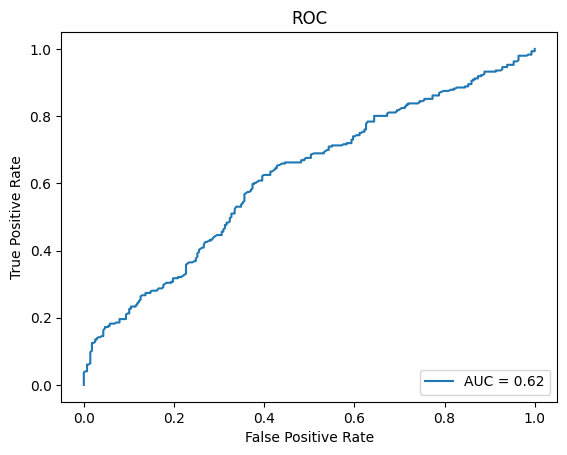

In [11]:
y = df_test.is_correct_pred
pred = df_test.expected_winner_prob
fpr, tpr, thresholds = roc_curve(y, pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(
    fpr=fpr, 
    tpr=tpr, 
    roc_auc=roc_auc,
)
display.plot()
plt.title('ROC')

## IMPROVEMENTS
* Grid Search over model parameter (zeta) and compare metrics between them
* Concept drift analysis: How to choose optimal retraining period?